In [1]:
#Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})
import tqdm
import sys
sys.path.append("../../")
from kooplearn.estimators import ReducedRank
from kooplearn.kernels import RBF

#To download these files, run "python get_dataset.py"
files = [
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz",
    "alanine-dipeptide-3x250ns-heavy-atom-distances.npz",
]

In [2]:
#Load the data on memory. The .npz files are comprised of three independent simulations ['arr_0', 'arr_1', 'arr_2']. Either of them can be used to train the model.
dihedrals = np.load("data/" + files[0])['arr_2'] #Dihedral angles \phi and \psi
distances = np.load("data/" + files[1])['arr_2'] #Distance between heavy atoms

#### An example from chemistry: the molecule Alanine dipeptide.
In this example we will analyse a [simulation of the molecule Alanine dipeptide](https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide) from the Computational Molecular Biology Group, Freie Universität Berlin (GER). 

<div>
<img src="../../complementary_figures/alanine_dipeptide_scheme.png" width="200"/>
</div>

The dataset, here, is a time series of the Alanine dipeptide atomic positions. The trajectory spans an interval of 250 nano-seconds. The number of features for each data point is 45.

For this example statistical mechanics provides quite a bit of informations:
1. The dynamics is governed by the Langevin equation, and is Markovian.
2. It exists an invariant density, dubbed the _Boltzmann distribution_ after the great physicist L. Boltzmann, one of the founding fathers of statistical mechanics. 
3. The equations are time-reversal-invariant. This implies that the Koopman operator is self-adjoint and has real eigenvalues.

For Alanine dipeptide it is well known that the dihedral angles (i.e. the ones annotated in the sketch above) play a special role, and characterize the _state_ of the molecule. Indeed, from the density plot shown below it is clear that only selected regions of the angle space are appreciably visited during the evolution of Alanine dipeptide. Broadly speaking, we can associate these regions to _metastable states_, i.e. configurations of the molecule which are "stable" over an appreciable span of time. To substantiate this claim we point to the plot in the right panel below. From this plot it is evident that when in a given region, the molecule spend a large amount of time inside it, and transitions from one region to another are quite rare. 

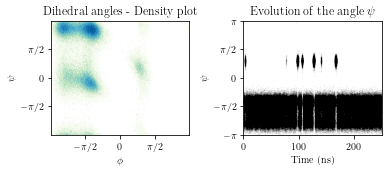

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize=(5.5,2.5))

#Ramachandran plot
ax[0].hexbin(dihedrals[:,0], dihedrals[:,1], cmap='GnBu', bins='log', gridsize=500)
ax[0].set_xlabel(r'$\phi$')
ax[0].set_ylabel(r'$\psi$')
ax[0].set_title(r'Dihedral angles - Density plot')
ax[0].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax[0].set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[0].set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[0].margins(0)

#Time-series plot of the angle \psi
ax[1].scatter(np.arange(dihedrals.shape[0])/1000, dihedrals[:,0], c='k', s=0.1, alpha=0.05)
ax[1].set_xlabel(r'Time (ns)')
ax[1].margins(0)
ax[1].set_ylabel(r'$\psi$')
ax[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax[1].set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax[1].set_title(r'Evolution of the angle $\psi$')
plt.tight_layout()
#fig.savefig('../../complementary_figures/ala2_ramachandran.jpg', dpi=300) #For Github
fig.savefig('ala2_ramachandran.png', dpi=300) #For publishing

We now try to recover the same informations from the spectral decomposition of the Koopman operator. We train the Reduced Rank Regression estimator with rank 5 and a standard Gaussian kernel. We remark that the dataset is comprised of atomic _positions_, and not dihedral angles. Later we will show that the computed eigenfunctions are highly correlated with the dihedral angles, meaning that our estimator was able to learn the correct physical quantities starting only from the raw atomic positions.  

In [6]:
kernel = RBF(length_scale=0.2)
params = {
    'kernel': kernel,
    'backend': 'numpy',
    'rank': 5,
    'svd_solver': 'arnoldi',
    'n_oversamples': 10,
    'iterated_power': 3
}
stride = 50 #We subsample the data to reduce the number of samples
X_train, Y_train = distances[::stride][:-1], distances[::stride][1:]
est = ReducedRank(**params, tikhonov_reg = 1e-4)
est.fit(X_train, Y_train)

ReducedRank(iterated_power=3,
            kernel=<kooplearn.kernels.RBF object at 0x7f6e1c4ac820>,
            svd_solver='arnoldi', tikhonov_reg=0.0001)

In [7]:
eigvals, right_funs = est.eig()

In [8]:
#The estimated eigenvalues are real (as they should be, since the system is time-reversal-invariant)
eigvals

array([ 0.99920225+0.j,  0.91773844+0.j,  0.47310195+0.j, -0.00425823+0.j,
       -0.02528168+0.j])

In [9]:
#We now evaluate the right eigenfunctions on the full simulation data.
eval_rf = right_funs(distances)

The eigenfunction corresponding to the largest eigenvalue is the equilibrium eigenfunction, and should be constant everywhere. 

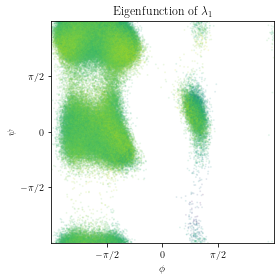

In [10]:
fig, ax = plt.subplots(figsize = (4,4))
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\psi$')
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax.margins(0)

ax.scatter(dihedrals[:,0], dihedrals[:,1], s=0.9, c=eval_rf[:,0], alpha=0.1)
ax.set_title(r"Eigenfunction of $\lambda_{1}$")
plt.tight_layout()
fig.savefig('../../complementary_figures/ala2_eq_eigenfunction.jpg', dpi=300)

The eigenfunction corresponding to the other leading eigenvalues corresponds to the slowest transition between metastable states, and takes different values in each of the region affected.

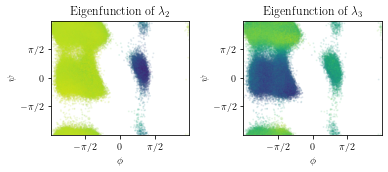

In [13]:
fig, axs = plt.subplots(ncols = 2, figsize = (5.5,2.5))
for ax_idx, ax in enumerate(axs):
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$\psi$')
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.margins(0)

    ax.scatter(dihedrals[:,0], dihedrals[:,1], s=0.9, c=eval_rf[:,ax_idx + 1], alpha=0.1)
    ax.set_title(r"Eigenfunction of $\lambda_{%d}$" % (ax_idx + 2))
plt.tight_layout()
#fig.savefig('../../complementary_figures/ala2_lead_eigenfunctions.jpg', dpi=300) #For Github
fig.savefig('ala2_lead_eigenfunctions.png', dpi=300) #For publishing

We see that when the value of the estimated Koopman eigenfunction is plotted against the dihedral angles, they take opposite values in regions corresponding to different local minima of the density.